# Chapter 5 深度神经网络-找出可能流失的客户

* 数据类型：
    * 结构化数据：有预先定义好的结构
    * 非结构化数据：没有什么预定义的数据结构，不方便用数据库存储，也不方便用Excel表格来表现的数据。
    
    
比如判断哪张照片属于什么类型就是非结构数据（也称感知类数据，人脑可以毫不费力的识别，但是计算机不行）\
**维度灾难**：高维度带来了超高的复杂度和超巨大的特征空间。\
神经网络的原理和线性回归或者逻辑回归相同---通过不断训练找出最佳参数！

***深度学习机理***： 用一串一串函数（层）不断堆叠起来，作用于输入数据，进行从原始数据到分类结果的过滤和提纯。

学习：就是为了神经网络的每一个层中的每个神经元寻找最佳的权重。


知识：学到的权重。
    

## 5.3 从感知器到单隐层网络

**Sigmoid函数**在逻辑回归中叫逻辑函数，在神经网络中则成为激活函数，用以类比人类神经系统中神经元的‘激活’过程。

* 输入空间：x
* 输出空间：y, actually y is less than x
* 特征空间： 每一个样本被称作一个实例，通常由特征向量表示，所有特征向量存在的空间被称为***特征空间***。 特征空间有时与输入空间相同，有时不同。因为有时候经过特征工程之后，输入空间可通过某种映射生成新的特征空间。
* 假设空间：一般是对学习到的模型（函数）而言的。模型表达了输入到输出的一种映射集合，这个集合就是假设空间。假设空间代表着模型学习过程中能够覆盖的最大范围。


**神经网络的上下标符号规则**：$w_{2.2}^{[1]}$中，*上*标的数字代表第几层，*下*标的数字有两个，第一个代表权重属于哪一个特征，即特征的维度；第二个代表其所连接到的下层神经元的维度。

## 5.4 用Keras单隐层网络预测客户流失率

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df_bank=pd.read_csv('BankCustomer.csv')
df_bank.head()

,Name,Gender,Age,City,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,Exited
0,Kan Jian,Female,40,Beijing,9,2,0,1,516,6360.66,0.0000,0
1,Xue Baochai,Male,69,Beijing,6,2,0,1,682,28605.00,0.0000,0
2,Mao Xi,Female,32,Beijing,9,1,1,1,803,10378.09,236311.0932,1
3,Zheng Nengliang,Female,37,Tianjin,0,2,1,1,778,25564.01,129909.8079,1
4,Zhi Fen,Male,55,Tianjin,4,3,1,0,547,3235.61,136976.1948,1


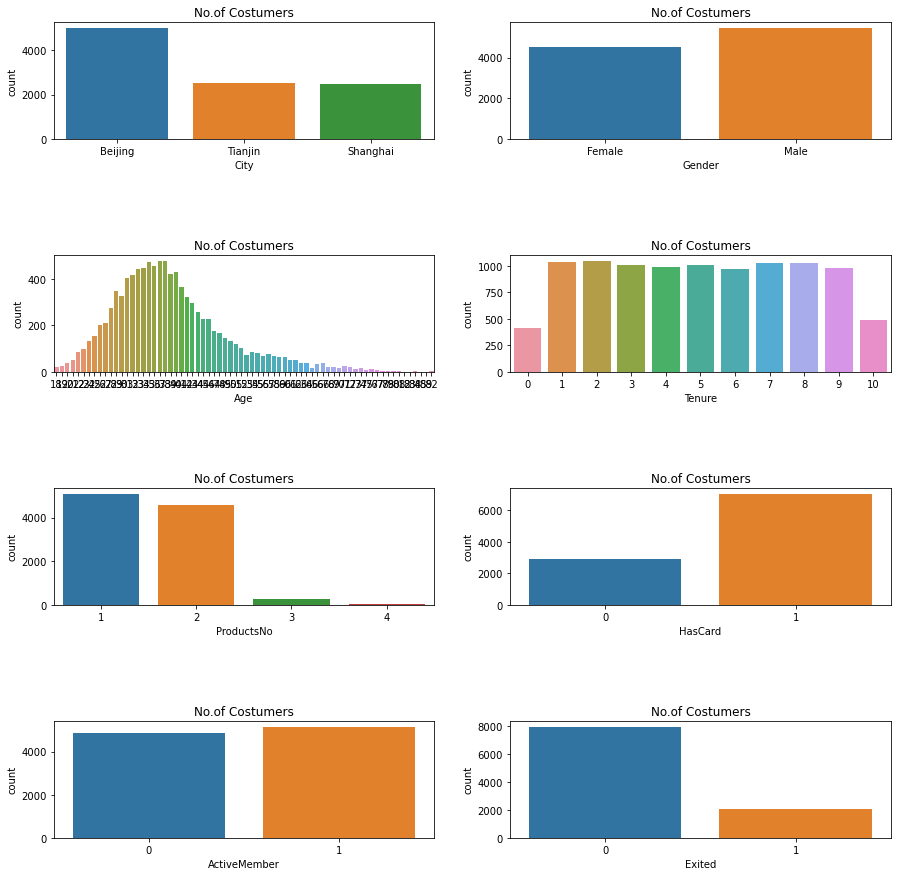

In [12]:
features=['City','Gender','Age','Tenure','ProductsNo','HasCard','ActiveMember','Exited']
fig=plt.subplots(figsize=(15,15))
for i,j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace=1.0)
    sns.countplot(x=j,data = df_bank)
    plt.title('No.of Costumers')
#这里我之前犯错了了，feature内部的名字，比如ProductsNo中间不要有空格，有空格就会报错！

从图中可以看出有三个需要从三个方向上来cleaning data:
    
    
* 性别：female 和male编程0/1代码，因为这属于’格式数据‘，在机器学习中需要转换成数字代码
* 城市：是多元类别特征，需要转换为多个二元类别哑变量
* 姓名与我们分析的问题无关，忽略掉。


In [14]:
df_bank['Gender'].replace('Female',0,inplace=True)
df_bank['Gender'].replace('Male',1,inplace=True)
print('Gender unique values',df_bank['Gender'].unique())

Gender unique values [0 1]


In [15]:
#对城市方面做data cleaning:转二元变量，然后再放回原始数据集
d_city=pd.get_dummies(df_bank['City'],prefix='City')
df_bank=[df_bank,d_city]#put bank to the data
df_bank=pd.concat(df_bank,axis=1)#axis=1表示横向对齐。
df_bank.head()

,Name,Gender,Age,City,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,Exited,City_Beijing,City_Shanghai,City_Tianjin
0,Kan Jian,0,40,Beijing,9,2,0,1,516,6360.66,0.0000,0,1,0,0
1,Xue Baochai,1,69,Beijing,6,2,0,1,682,28605.00,0.0000,0,1,0,0
2,Mao Xi,0,32,Beijing,9,1,1,1,803,10378.09,236311.0932,1,1,0,0
3,Zheng Nengliang,0,37,Tianjin,0,2,1,1,778,25564.01,129909.8079,1,0,0,1
4,Zhi Fen,1,55,Tianjin,4,3,1,0,547,3235.61,136976.1948,1,0,0,1


关于pd.concat（数据的合并与重塑）见这里：[pd.concat中问](https://blog.csdn.net/stevenkwong/article/details/52528616),非常好的中文说明！

In [17]:
#构建特征和数据标签。
y=df_bank['Exited']
X=df_bank.drop(['Name','Exited','City'],axis=1)
X.head()
#数据标签一共有12个维度

,Gender,Age,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,City_Beijing,City_Shanghai,City_Tianjin
0,0,40,9,2,0,1,516,6360.66,0.0000,1,0,0
1,1,69,6,2,0,1,682,28605.00,0.0000,1,0,0
2,0,32,9,1,1,1,803,10378.09,236311.0932,1,0,0
3,0,37,0,2,1,1,778,25564.01,129909.8079,0,0,1
4,1,55,4,3,1,0,547,3235.61,136976.1948,0,0,1


In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [19]:
#尝试先用Sklearn逻辑回归算法看一下：
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
history=lr.fit(X_train,y_train)
print('逻辑回归的预测准确率为：{:.2f}%'.format(lr.score(X_test,y_test)*100))

逻辑回归的预测准确率为：78.35%


In [31]:
#使用Keras package 构建sequence网络
import keras 
from keras.models import Sequential
from keras.layers import Dense
ann=Sequential()#构建一个Sequential ann模型
ann.add(Dense(units=12,input_dim=12,activation='relu'))#添加输入层
ann.add(Dense(units=24,activation='relu'))
ann.add(Dense(units=1,activation='sigmoid'))
ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_6 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 493
Trainable params: 493
Non-trainable params: 0
_________________________________________________________________


***Sequential***也叫顺序模型，是最常用的深度网络层和层间结构，也就是一层接一层，顺序地堆叠。

***Dense***是最常用的深度网络层的类型，也称为全连接层，即当前层和其下一层的所有神经元之间全有连接。

In [23]:
#显示出神经网络形状的另一种方法：
from Ipython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG((model_to_dot(ann,show_shape=True).create(prog='dot',format='svg')))

ModuleNotFoundError: No module named 'Ipython'

In [33]:
#编译神经网络，指定优化器，损失函数，以及评估指标
ann.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [29]:
#使用Keras先训练着我们的单隐层神经网络
#先修改之前的维度由11修改成12,因为我们X_train是12维
ann.add(Dense(units=12,input_dim=12,activation='relu'))
#书里介绍有些出入，如果单输入这一行之后，还是会报错，要在后边加上ann.compile（）命令才会生效。所以我为了省事，直接在原来的代码处吧input_dim=11改成了12


In [34]:
history=ann.fit(X_train,y_train,epochs=30,batch_size=64,validation_data=(X_test,y_test))#epochs指定轮次

Epoch 1/30
125/125 [==============================] - 9s 5ms/step - loss: 950.2191 - acc: 0.6827 - val_loss: 144.3540 - val_acc: 0.7370
Epoch 2/30
125/125 [==============================] - 0s 2ms/step - loss: 111.2014 - acc: 0.6480 - val_loss: 17.7266 - val_acc: 0.6615
Epoch 3/30
125/125 [==============================] - 0s 2ms/step - loss: 51.9573 - acc: 0.6451 - val_loss: 25.8654 - val_acc: 0.7245
Epoch 4/30
125/125 [==============================] - 0s 2ms/step - loss: 68.3972 - acc: 0.6746 - val_loss: 99.8630 - val_acc: 0.7915
Epoch 5/30
125/125 [==============================] - 0s 2ms/step - loss: 88.8836 - acc: 0.6753 - val_loss: 22.0296 - val_acc: 0.7820
Epoch 6/30
125/125 [==============================] - 0s 3ms/step - loss: 54.2569 - acc: 0.6736 - val_loss: 33.4117 - val_acc: 0.2765
Epoch 7/30
125/125 [==============================] - 0s 2ms/step - loss: 39.8489 - acc: 0.6737 - val_loss: 57.0900 - val_acc: 0.7915
Epoch 8/30
125/125 [==============================] - 0s 2m

In [37]:
#为了避免输出向上面一行代码那样给出30轮每一轮的信息，可以把这些信息转换成学习曲线
def show_history(history):
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(1,len(loss)+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,'go',label='Training loss')
    plt.plot(epochs,val_loss,'g',label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    plt.subplot(1,2,2)
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

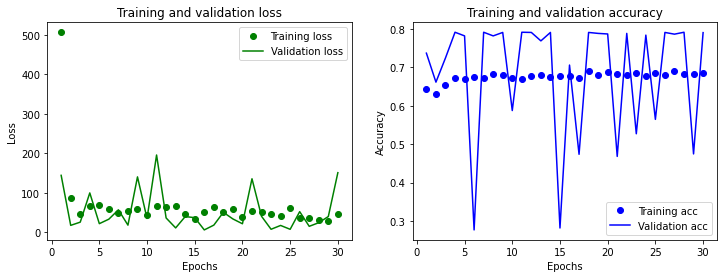

In [38]:
show_history(history)

## 5.5 分类数据不平衡问题：只看准确率够用吗

* Confusion matrix
    * True negative (TN)
    * False Positive (FP)
    * False Negative (FN)
    * True Positive (TP)

精确率(查准率）：
$$Precision=\frac{TP}{TP+FP}=\frac{TP}{Total\ Predicted\ Positive}$$
召回率（查全率）：
$$Recall = \frac{TP}{TP+FP}=\frac{TP}{Total\ True\ Positive}$$
F1 Score:
$$F1=2\cdot\frac{Precision \cdot Recall}{Precision + Recall}$$


In [41]:
#用neutral network中的predict方法来预测测试集的分类标签，然后把真值和预测值进行比较，并利用sklearn package 的classification计算上面式子
from sklearn.metrics import classification_report
y_pred=ann.predict(X_test,batch_size=10)
y_pred=np.around(y_pred)#四舍五入，将分类概率值转换成0/1整数值
y_test=y_test.values #将pandas里面的series转换成numpy中的array
y_test=y_test.reshape((len(y_test),1))#目的是和y_pred相同的形状
print(classification_report(y_test,y_pred,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1583
           1       0.38      0.01      0.01       417

    accuracy                           0.79      2000
   macro avg       0.58      0.50      0.45      2000
weighted avg       0.71      0.79      0.70      2000



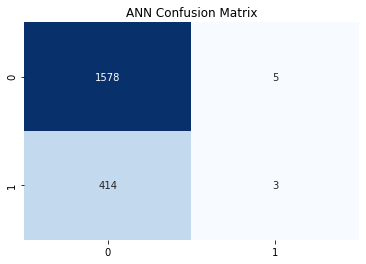

In [42]:
#画出混淆矩阵
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
plt.title('ANN Confusion Matrix')
sns.heatmap(cm,annot=True,cmap='Blues',fmt='d',cbar=False)
#annot: bool or rectangular datasets, if true: write the datasets
#fmt:String formatting code to use when adding annotations.
plt.show()


***特征缩放(Feature Scaling)***对于神经网络来说特别重要！
对数据进行标准化，主要是先减去mean, 在除以std.

或者也可以采用sklearn.prepocessing中的StandardScaler来进行缩放


In [43]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [45]:
X_test.dtype

dtype('float64')

In [46]:
#测试缩放后，效果有什么不同，先进行logisticregression方式
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
history=lr.fit(X_train,y_train)
print('逻辑回归预测准确率{:.2f}%'.format(lr.score(X_test,y_test)*100))

逻辑回归预测准确率80.50%


In [51]:
history=ann.fit(X_train,y_train,epochs=30,batch_size=64,
                validation_data=(X_test, y_test))

Epoch 1/30
125/125 [==============================] - 1s 6ms/step - loss: 0.4776 - acc: 0.7943 - val_loss: 0.4692 - val_acc: 0.7925
Epoch 2/30
125/125 [==============================] - 0s 3ms/step - loss: 0.4598 - acc: 0.7976 - val_loss: 0.4607 - val_acc: 0.7920
Epoch 3/30
125/125 [==============================] - 0s 3ms/step - loss: 0.4521 - acc: 0.7983 - val_loss: 0.4515 - val_acc: 0.7905
Epoch 4/30
125/125 [==============================] - 0s 3ms/step - loss: 0.4384 - acc: 0.8024 - val_loss: 0.4333 - val_acc: 0.8050
Epoch 5/30
125/125 [==============================] - 0s 3ms/step - loss: 0.4193 - acc: 0.8180 - val_loss: 0.4165 - val_acc: 0.8175
Epoch 6/30
125/125 [==============================] - 0s 3ms/step - loss: 0.4053 - acc: 0.8249 - val_loss: 0.4060 - val_acc: 0.8215
Epoch 7/30
125/125 [==============================] - 0s 3ms/step - loss: 0.3959 - acc: 0.8317 - val_loss: 0.4008 - val_acc: 0.8240
Epoch 8/30
125/125 [==============================] - 0s 3ms/step - loss: 0.

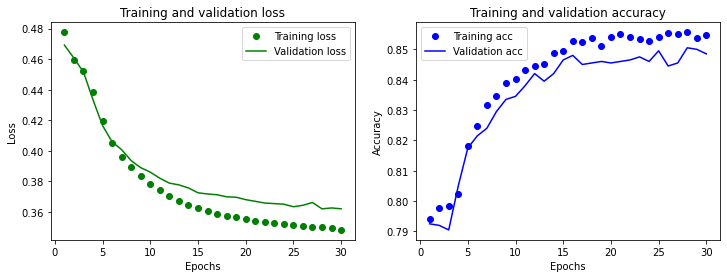

In [52]:
show_history(history)

## 5.6从单隐层神经网络到深度神经网络

深度神经网络的梯度下降和参数优化过程是通过**优化器**来实现的，其中包括**正向传播（Forward Propagation)**, 以及**反向传播（Back Propagation, BP)**

正向传播：从数据的输入，一层一层进行输入和输出传递，直到得到最后一层的预测结果，然后计算损失值的过程

反向传播：反向计算偏微分，信息会从神经网络的高层向底层反向传播，并在这个过程中根据输出来调整权重。

* 各种优化器的特点
    * 批量梯度下降（Batch Gradient Descent, BGD)：\
        通过拆分成小批量，来通过向量化计算方式进行处理
    * 随机梯度下降 (Stochastic Gradient Descent, SGD):\
        随机选择一个样本来更新模型参数--每轮次的学习速度非常快，但是所需更新的轮次也特别多。通过keras.optimizers.SGD来调用
    * 小批量随机梯度下降（Mini-Batch Gradient Descent, MBGD):\
        在更新速度和更新轮次中间取得了一个平衡。
    * 动量SGD: \
        更新参数w时不仅要考虑当前的梯度，还要考虑上一次的参数更新
    * 上坡时减少动量————NAG(Nesterov Accelerated Gradient):\
        下坡加动量，上坡减少动量
    * 各参数不同的学习速率———Adagrad(Adaptive Gradient):\
        不同的参数拥有不同的学习速率，通过keras.optimizers.adagrad()来调用。Adagrad有一个类似的变体叫Ada Delta， 就是在每次迭代时用梯度实时构造参数的更新值。
    * 加权平均值计算二阶动量——RMSProp(Root Mean Square Propogation):\
        目的是解决Adagrad学习速率有时急剧下降的问题。采用窗口滑动加权平均值计算二阶动量。通过keras.optimizers.RMSprop()来调用
    * 多钟优化思路的集大成者——Adam（Adaptive Moment Estimation，相当于Adaptive+Momentum)
    * Nesterov Adam Optimizer（Nadam)——结合Adam+Nesterov Momentum. 
        
    

* **激活函数**（在逻辑回归中，输入的特征通过加权、求和后，还将通过一个sigmoid逻辑函数讲线性回归值压缩在[0,1]区间，以体现概率值：
    * 可以理解为神经网络从线性变换到非线性变换的过程。
    


* 激活函数种类：
    * Sigmoid 函数：\
        缺点：会出现梯度消失(gradient Vanishing)
    * Tanh 函数（可以将连续实数映射到[-1,1]区间）：
        $$f(z)=tanh(z)=\frac{e^z-e^{-z}}{e^z+e^{-z}}$$
    * Re LU 函数（Rectified Linear Unit):\
        特点是单侧抑制，当输入信号小于等于0时，输出是0；当输入信号大于0时，输出等于输入。
        $$f(z)=\max(0,z)$$
        注意：使用Re Lu时，学习速率绝对不能设的太大，因为那样会‘杀死’网络中的很多神经元。
    * Leaky Re LU和PRe LU:
        $$f(z)=\max(\epsilon z,z)$$
        
    * e LU 函数：
    $$f(z)=z, \ if z\geq0$$
    $$f(z)=\epsilon(e^z-1),\ if z<0$$
        
        